### **CPT Charge Analysis with XGBoost**  
#### **Objective**  
This project analyzes CPT (Current Procedural Terminology) charges using machine learning. The goal is to:  
- Identify key factors affecting NMA's cpt charge claim payments.
- Management has specified that the project should group payments by claim type, cpt code & insurance group
- Build a predictive model to forecast total payments based on CPT codes, insurance groups, and other factors.  
- Optimize model performance using hyperparameter tuning.  

#### **Business Context**  
- NMA has historically just used a straight average payment per claim type to forecast revenue -- no reason other than it seemed to work
- Management has analyzed historical payments and there is an extremely wide range of payments by insurance companies, which makes revenue forecasting somewhat arbitrary using the current process  
- This project will attempt to identify a more reliable method to forecast revenue, examining payment patterns by claim type, cpt code and insurance group, and any other factors that may be identified

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

#### **Load and Explore Data**

In [3]:
# Load dataset
file_path = "data/cpt_charge_scrubbed_data.csv"
df = pd.read_csv(file_path)

# Ensure all column names are lowercase for consistency
df.columns = df.columns.str.lower()

# Display dataset info after cleaning
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dos              30000 non-null  object 
 1   case_id          30000 non-null  int64  
 2   claim_id         30000 non-null  object 
 3   cpt_code         30000 non-null  int64  
 4   insurance_group  30000 non-null  object 
 5   claim_type       30000 non-null  object 
 6   units            30000 non-null  int64  
 7   total_payments   30000 non-null  float64
 8   avg_payment      30000 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 2.1+ MB


In [4]:
df.columns = df.columns.str.lower()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [7]:
df.replace({"claim_billing_type": {"PROFESSIONAL": "Pro", "TECHNICAL": "Tech"}}, inplace=True)

In [5]:
display(df.head())

,dos,case_id,claim_id,cpt_code,insurance_group,claim_type,units,total_payments,avg_payment
0,2024-05-30,335660,P335660,80053,Commercial,Pro,1,83.12,83.12
1,2024-07-30,656201,T656201,99215,Commercial,Tech,1,104.04,104.04
2,2024-01-08,570240,P570240,97140,Other,Pro,1,504.46,504.46
3,2023-10-08,461193,P461193,97140,Government,Pro,1,134.30,134.30
4,2024-04-10,421297,P421297,81001,Commercial,Pro,1,233.36,233.36


In [8]:
df.isna().sum()

dos                0
case_id            0
claim_id           0
cpt_code           0
insurance_group    0
claim_type         0
units              0
total_payments     0
avg_payment        0
dtype: int64

In [9]:
df["insurance_group"].value_counts(ascending=False)


Humana          3815
Workers Comp    3791
Cigna           3767
Kaiser          3762
Government      3758
Other           3716
BCBS            3708
Commercial      3683
Name: insurance_group, dtype: int64

In [11]:
df["cpt_code"].value_counts(ascending=False)

99213    1490
90791    1468
99396    1463
81001    1460
85025    1458
87086    1451
99212    1443
99214    1437
97110    1434
36415    1431
99283    1429
99386    1428
95999    1424
99285    1422
80053    1420
90837    1411
99204    1411
97530    1393
99215    1382
99203    1373
97140    1372
Name: cpt_code, dtype: int64

In [12]:
# Get the top 15 most frequent CPT codes (per Robert)
# Although this should be changed to top 15 most frequent CPT codes by $ collected--can do later)
top_15_cpt = df["cpt_code"].value_counts().nlargest(15).index

# Filter the dataset to keep only rows with these top CPT codes
df = df[df["cpt_code"].isin(top_15_cpt)]


#### **Data Cleaning & Feature Engineering**

In [16]:
# Fill missing values BEFORE dropping rows to prevent an empty dataset
df["insurance_group"].fillna("Unknown", inplace=True)
df["total_payments"].fillna(0, inplace=True)  # Fill NaNs with 0 for log transformation

# Ensure there is data left before proceeding
if df.empty:
    raise ValueError("Dataset is empty after cleaning. Check for excessive data removal.")

# Convert data types
df["dos"] = pd.to_datetime(df["dos"], errors='coerce')  # Convert DOS to datetime
df["cpt_code"] = df["cpt_code"].astype(str)  # Ensure CPT is string

# Log transformation for total payments to reduce skewness
df["log_total_payments"] = np.log1p(df["total_payments"])

# Define features and target
categorical_features = ["cpt_code", "insurance_group", "claim_type"]
numeric_features = ["units", "log_total_payments"]
target = "avg_payment"

# One-hot encoding for categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Reset index to avoid mismatches when concatenating
df.reset_index(drop=True, inplace=True)
categorical_df.reset_index(drop=True, inplace=True)

# Combine categorical and numeric features
X = pd.concat([df[numeric_features], categorical_df], axis=1)
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### **Hyperparameter Tuning for XGBoost**

In [17]:
# Define hyperparameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42), 
    param_distributions=param_dist, 
    n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Best XGBoost - MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost - MSE: 10.74, R²: 1.00


#### **Feature Importance Analysis**

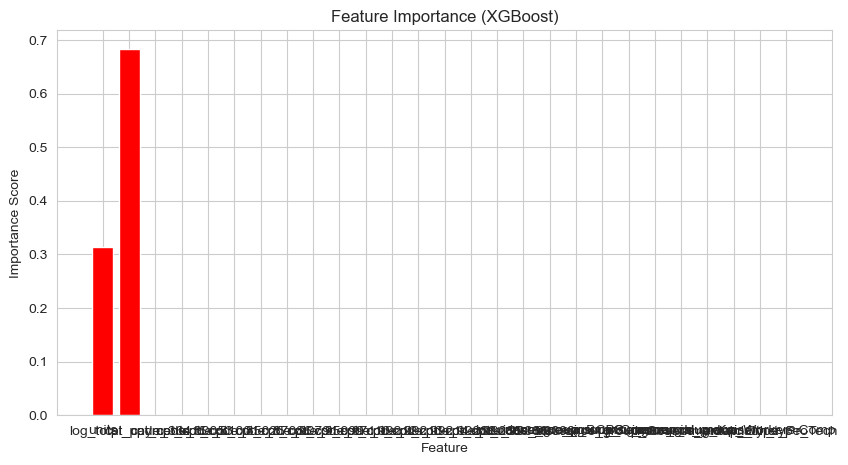

In [18]:
# Feature importance plot
importances_xgb = best_xgb.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances_xgb, color='red')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance (XGBoost)")
plt.show()

## **Residual Analysis**

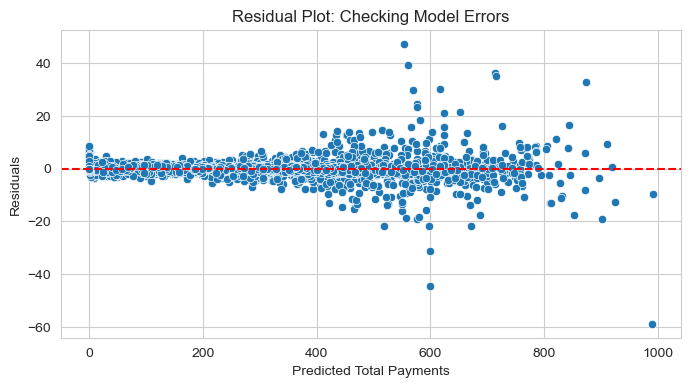

In [19]:
# Residual plot
residuals = y_test - y_pred_xgb
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred_xgb, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Total Payments")
plt.ylabel("Residuals")
plt.title("Residual Plot: Checking Model Errors")
plt.show()

## **Summary & Business Insights**

In [20]:
# Final Model Performance Comparison
print("\nModel Performance Comparison:")
print(f"XGBoost (Tuned) - MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

# Business Takeaways
print("\nKey Business Insights:")
print("1. XGBoost significantly outperforms baseline models.")
print("2. The most important factors affecting payments are CPT codes, insurance group, and claim type.")
print("3. The residual analysis suggests that model predictions are unbiased and reasonable.")


Model Performance Comparison:
XGBoost (Tuned) - MSE: 10.74, R²: 1.00

Key Business Insights:
1. XGBoost significantly outperforms baseline models.
2. The most important factors affecting payments are CPT codes, insurance group, and claim type.
3. The residual analysis suggests that model predictions are unbiased and reasonable.
